A simple classifier for detecting ELMs in the dAlpha dataset. The ELM detection algorithm is first applied to identify ELM time points, from which fixed-length (N) ELM contexts are sampled using a normal distribution. An equal number of non-ELM contexts are extracted from background regions. This classifier only detects the presence/absence of ELMs but does not classify their types.

## Extract dalpha from storage

In [ ]:
import zarr
import s3fs
import fsspec
import numpy as np
import xarray as xr

start_id = 30000
num_files = 1000
save_dir = './data/dalpha'
shutil.rmtree(save_dir, ignore_errors=True)
os.makedirs(save_dir, exist_ok=True)

endpoint_url = 'https://s3.echo.stfc.ac.uk'

for i in tqdm(range(num_files)):
    
    url = f's3://mast/test/level2/shots/{start_id+i}.zarr'
    
    fs = fsspec.filesystem(
      **dict(
        protocol='simplecache',
        target_protocol="s3",
        target_options=dict(anon=True, endpoint_url=endpoint_url)
      )
    )
    try:
        store = zarr.storage.FSStore(fs=fs, url=url)
        profiles = xr.open_zarr(store, group='dalpha')
        profiles = profiles.dropna(dim='time')
        df = profiles.to_pandas()
        df.to_csv(f"{save_dir}/{start_id+i}.csv", index=True)
        # print(.shape) 
    except Exception:
        continue
        

# Load dalpha dataframes 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def background_subtract(values, dtime, moving_av_length=0.001):
    values = values.copy()
    
    dt = dtime[1]-dtime[0]
    n = int(moving_av_length/dt)
    ret = np.cumsum(values, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret = ret[n - 1:] / n
    values[n - 1:] -= ret
    
    return values
    
data_dir = '/home/ubuntu/Projects/UKAEA-ML-VIS/data/dalpha'
data_files = sorted(os.listdir(data_dir))
print(f"{len(data_files)=} files found. ")

# start_time, end_time = 0.135, 0.215
start_time, end_time = 0.1, 0.3

dalpha_values = {}
dalpha_times = {}
for file in tqdm(data_files):
    df = pd.read_csv(f"{data_dir}/{file}")
    df = df[(df['time'] >start_time) & (df['time'] < end_time)]
    file_id = file.split('.')[0]
    try:
        df = df.dropna(subset=['dalpha_mid_plane_wide'])
        dalpha_values[file_id] = background_subtract(df.dalpha_mid_plane_wide.values, df.time.values).astype(np.float32) # some df doesn't have mid_plane
        dalpha_times[file_id] = df.time.values
    except Exception:
        continue

print(f"{len(dalpha_values)} signals loaded sucessfully !!!")

len(data_files)=331 files found. 


100%|██████████| 331/331 [00:05<00:00, 58.72it/s]

329 signals loaded sucessfully !!!


## Visualize dalpha

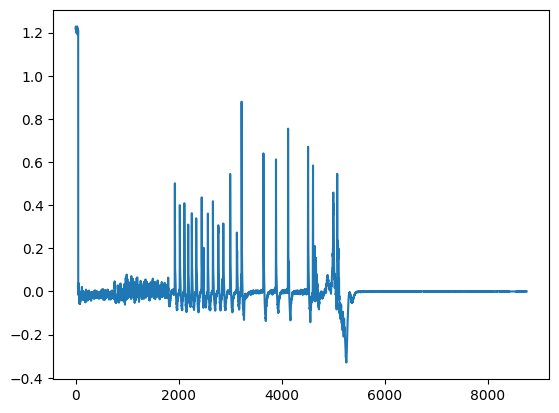

In [2]:
shot_id = '30462'
plt.plot(dalpha_values[shot_id])

## Sample ELMs and Non-ELMs contexts

In [7]:
import random
import torch
from scipy.interpolate import interp1d

import numpy as np

def set_random_seed(seed):
    #setup seeds
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
def identify_bursts(series,thresh,analyse=True):
    # a handy function from Nick Walkdens time series tools. Thanks Nick!
    
    inds_above_thresh = np.where(series>thresh)
    inds_below_thresh = np.where(series<=thresh)
    windows = []
    leng = len(inds_above_thresh[0])+0.0
    for i, ind in enumerate(inds_above_thresh[0]):
      # if i%250==0:
      #   perc_done = (i/leng)*100
      #   print('%0.1f'%perc_done)
      try:
          #Extract highest possible index that occurs before a filement,
          ind_low = np.extract(inds_below_thresh < ind,inds_below_thresh)[-1]
          #Extract lowest possible index that occurs after a filemant
          ind_up = np.extract(inds_below_thresh > ind,inds_below_thresh)[0]
          if (ind_low,ind_up) not in windows:
              #Make sure that there is no double counting
              windows.append((ind_low,ind_up))
      except:
          pass
    if analyse:
      N_bursts = len(windows)
      burst_ratio = len(list(series))/N_bursts
      av_window = np.mean([y - x for x,y in windows])
      return windows,N_bursts,burst_ratio,av_window
    else:
      return windows
      
def detect_elms(dalpha, dtime, thresh=0.1, min_elm_duration=0.05*1e-3, max_elm_duration=50*1e-3, min_elm_seperation=1.5*1e-3):
    
    windows = identify_bursts(dalpha, thresh=thresh, analyse=False)
    
    # filter spikes too short to be elms
    for i in range(len(windows)):
        if (dtime[windows[i][1]]-dtime[windows[i][0]])<min_elm_duration:
          windows[i]=(0,0)
            
        if (dtime[windows[i][1]]-dtime[windows[i][0]])>max_elm_duration:
          windows[i]=(0,0)
    
    windows = [x for x in windows if x!=(0,0)]
    
    elm_inds = [np.argmax(dalpha[window[0]:window[1]]) + window[0] for window in windows]
    
    elm_heights = dalpha[elm_inds]
    elm_times = dtime[elm_inds]
    freq_filtered_inds = np.zeros(0,dtype=int)
    for i in range(len(elm_inds)-1):
        if elm_heights[i]!=0 and i not in freq_filtered_inds:
          close_inds = np.where(elm_times[i+1:]-elm_times[i]<min_elm_seperation)[0]+i+1
          freq_filtered_inds=np.concatenate((freq_filtered_inds,close_inds))
    
    freq_filtered_inds = np.unique(freq_filtered_inds)
    
    elm_inds = np.setdiff1d(elm_inds, freq_filtered_inds)
    
    return elm_inds, freq_filtered_inds

def sample_signal(signal, indices, sample_len, scale_factor=100, samples_per_indices=1):
    """
    Sample a signal around the indices location
    Args:
        singal (np.array): 1D signal of length N
        indices (list or np.array): List of indices in the signal from where values are sampled. 
        sample_len (int): Length of the sampled signal
        scale_factor (float): Scale factor of the Normal Distributions. Determine deviations of the indices. Must be >= 1. 
        sample_per_indices (int): Number of samples to be sampled from each indices. 

    Return:
        sampled_indices (np.ndarray): Array of shape (num_samples, len(indices))
        sampled_signal (np.ndarray): Sampled array of shape (num_samples, len(indices), sample_len)
    """
    indices = torch.tensor(indices, dtype=torch.float32)
    
    # find indices of elm
    indices = indices[(indices-sample_len//2)>0]
    indices = indices[(indices+sample_len//2)<len(signal)]
    
    # Create a normal distributions of elm indices
    t_dist = torch.distributions.normal.Normal(loc=indices, scale=scale_factor*torch.ones_like(indices))
    sampled_indices = t_dist.sample((samples_per_indices, )) # (num_samples, num_indices)
    
    # Sample random indices around each index
    offsets = torch.arange(-sample_len//2, sample_len//2).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, sample_len)
    sampled_indices = sampled_indices.unsqueeze(-1) + offsets  # Shape: (num_samples, num_indices, sample_len)
    sampled_indices = sampled_indices.clamp(0, len(signal)-1).to(int).numpy()
    
    sampled_signal = []
    for indices in sampled_indices:
        sampled_signal.append(signal[indices])
    
    return sampled_indices, np.array(sampled_signal)

def segment_dalpha(dalpha, segment_length=512):
    # Compute the number of full segments
    total_length = len(dalpha)
    num_segments = int(np.ceil(total_length / segment_length))
    # num_segments = total_length//segment_length
    
    # Initialize an array filled with NaN for all segments
    segmented_dalpha = np.full((num_segments, segment_length), np.nan, dtype=np.float32)

    # Fill the array with time series data
    for i in range(num_segments):
        start_idx = i * segment_length
        end_idx = min(start_idx + context_length, total_length)
        segment = time_series[start_idx:end_idx]
        segmented_dalpha[i, :len(segment)] = segment

    return segmented_dalpha

context_length = 256
dalpha_elms = {}
dalpha_non_elms = {}
set_random_seed(42)
for shot_id in tqdm(dalpha_values.keys()):

    dalpha = dalpha_values[shot_id].copy()
    dtime = dalpha_times[shot_id].copy()
    
    elm_inds, filtered_inds = detect_elms(dalpha, dtime, thresh=0.2)

    if not len(elm_inds)>3:
        continue
        
    sampled_elm_inds, sampled_elms = sample_signal(dalpha, elm_inds, context_length, samples_per_indices=2)
    
    # sample non_elm 
    non_elm_inds = np.arange(0, np.min(elm_inds)).tolist() + np.arange(np.max(elm_inds), len(dalpha)).tolist()
    non_elm_inds = np.random.choice(non_elm_inds, len(elm_inds)) 
    sampled_non_elm_inds, sampled_non_elms = sample_signal(dalpha, non_elm_inds, context_length, scale_factor=1, samples_per_indices=2)

    dalpha_elms[shot_id] = torch.tensor(sampled_elms).flatten(0, 1) # (num_elms, context_length)
    dalpha_non_elms[shot_id] = torch.tensor(sampled_non_elms).flatten(0, 1) # (num_elms, context_length)
    

100%|██████████| 329/329 [00:02<00:00, 133.12it/s]


In [27]:
import pickle
with open('./data/dalpha_elms.pkl', 'wb') as f:
    pickle.dump(dalpha_elms, f)
with open('./data/dalpha_non_elms.pkl', 'wb') as f:
    pickle.dump(dalpha_non_elms, f)

In [29]:
len(dalpha_values.keys())

329

## Visualize sampled ELMs

elm_inds=array([1925, 2021, 2109, 2184, 2254, 2339, 2446, 2566, 2664, 2769, 2866,
       2999, 3129, 3221, 3645, 3889, 4124, 4512, 4608, 5002, 5078, 5093])


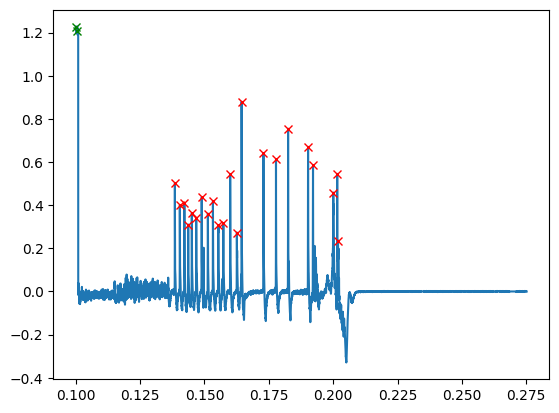

non_elm_inds=array([8714, 7570, 8042, 5719, 6825,    7, 5723,  475, 8584, 5379,  484,
       8168, 7822, 5453, 8391, 8497, 7731, 6693, 6507, 5990, 8111, 6092])


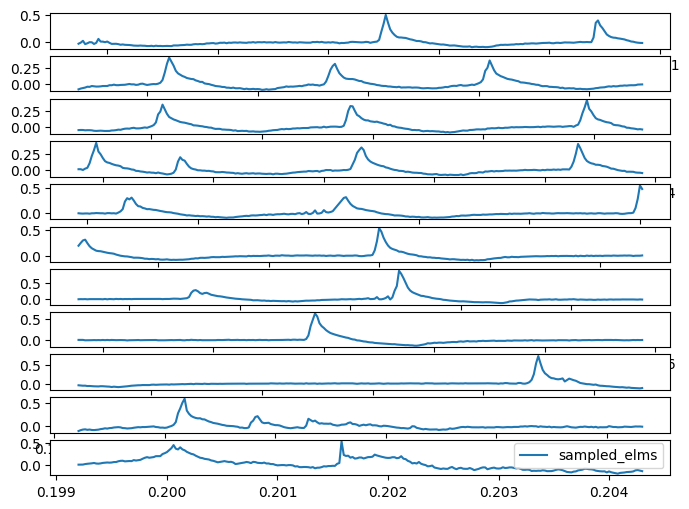

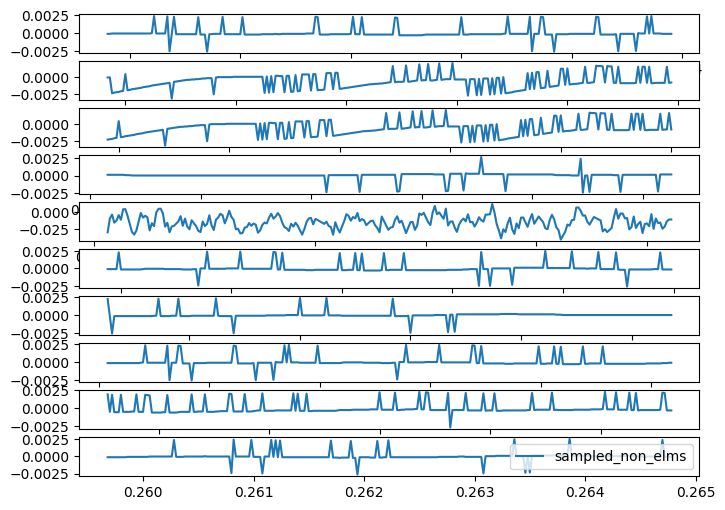

In [8]:
shot_id = '30462'

dalpha = dalpha_values[shot_id].copy()
dtime = dalpha_times[shot_id].copy()

elm_inds, filtered_inds = detect_elms(dalpha, dtime, thresh=0.2)
print(f"{elm_inds=}")

fig, axes = plt.subplots()
axes.plot(dtime, dalpha, label='dalpha')
axes.plot(dtime[elm_inds], dalpha[elm_inds], 'xr', label='elm_times')
axes.plot(dtime[filtered_inds], dalpha[filtered_inds], 'xg', label='filtered')
plt.show()

sampled_elm_inds, sampled_elms = sample_signal(dalpha, elm_inds, context_length, samples_per_indices=2)
# plot sampled elms
plt.close('all')
step_size = 2
n_rows = int(np.ceil(sampled_elms.shape[1]/step_size))
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 6))
for i in np.arange(0, sampled_elms.shape[1], step_size):
    axes[i//step_size].plot(dtime[sampled_elm_inds[0][i]], sampled_elms[0][i], label='sampled_elms')
plt.legend()

# sample non_elm
non_elm_inds = np.arange(0, np.min(elm_inds)).tolist() + np.arange(np.max(elm_inds), len(dalpha)).tolist()
non_elm_inds = np.random.choice(non_elm_inds, len(elm_inds))
print(f"{non_elm_inds=}")

sampled_non_elm_inds, sampled_non_elms = sample_signal(dalpha, non_elm_inds, context_length, scale_factor=1, samples_per_indices=1)

# plot sampled non elms
n_rows = int(np.ceil(sampled_non_elms.shape[1]/step_size))
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 6))
for i in np.arange(0, sampled_non_elms.shape[1], step_size):
    axes[i//step_size].plot(dtime[sampled_non_elm_inds[0][i]], sampled_non_elms[0][i], label='sampled_non_elms')
plt.legend()

### Create Train/Test data

In [9]:
# positive samples
test_shot_ids = ['30460', '30461', '30462', '30463', '30464', '30465']

train_positives = torch.cat([v for k, v in dalpha_elms.items() if k not in test_shot_ids]) # (N, context_length)
train_negatives = torch.cat([v for k, v in dalpha_non_elms.items() if k not in test_shot_ids])

n_positives = len(train_positives)
n_negatives = len(train_negatives)

if n_positives>n_negatives:
    # downsample positive_class
    train_positives = train_positives[torch.randperm(n_positives)][:n_negatives]
elif n_negatives>n_positives:
    train_negatives = train_negatives[torch.randperm(n_negatives)][:n_positives]

train_data = torch.cat([train_positives, train_negatives]).to(torch.float32)
train_labels = torch.cat([
    torch.tensor([[0, 1]] * len(train_positives)),  # One-hot for positives
    torch.tensor([[1, 0]] * len(train_negatives))   # One-hot for negatives
]).to(torch.float32)

print(train_data.shape, train_labels.shape)


torch.Size([9676, 256]) torch.Size([9676, 2])


### Train a simple classifier using Unsupervised Learning

In [22]:
import os
import io
import sys
import csv
import h5py
import json
import math
import time
import importlib
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
        
class SingleConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, drop=0,
                 conv_layer=nn.Conv1d, norm_layer=nn.Identity):
        super().__init__()
        self.single_conv = nn.Sequential(
            conv_layer(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            nn.ReLU(),
            nn.Dropout(drop),
        )
    def forward(self, x):
        return self.single_conv(x)
        
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, 
                 conv_layer=nn.Conv1d, activation=nn.ReLU, norm_layer=nn.Identity):
        super().__init__()

        self.double_conv = nn.Sequential(
            conv_layer(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            norm_layer(out_channels),
            activation(),
            conv_layer(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
            norm_layer(out_channels),
            activation(),
            conv_layer(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            norm_layer(out_channels),
            activation(),
        )

    def forward(self, x):
        return self.double_conv(x)
        
        
class Network(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=256, code_dim=64, output_dim=2, **kwargs):
        super().__init__()
        
        self.in_channels = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.mlp = nn.Sequential(
            SingleConv(input_dim, 16, kernel_size=7, stride=1, padding=3, norm_layer=nn.BatchNorm1d),
            nn.MaxPool1d(4),
            DoubleConv(16, 32, kernel_size=3, stride=1, padding=1, norm_layer=nn.BatchNorm1d),
            nn.MaxPool1d(4),
            SingleConv(32, hidden_dim, kernel_size=3, stride=1, padding=1, norm_layer=nn.BatchNorm1d),
            # nn.AdaptiveMaxPool1d(1)
        )

        self.pool1d = nn.AdaptiveAvgPool1d(1)
        
        self.linear_head = nn.Linear(hidden_dim, output_dim)

        self.bce_loss = nn.BCELoss()

    def instance_norm(self, x, epsilon=1e-5):
        # Compute mean and variance along the L dimension (axis=2)
        mean = x.mean(dim=2, keepdim=True)  # Shape: (N, D, 1)
        var = x.var(dim=2, keepdim=True, unbiased=False)  # Shape: (N, D, 1)
        
        # Normalize
        x_normalized = (x - mean) / torch.sqrt(var + epsilon)  # Shape: (N, D, L)
        return x_normalized
    
    def forward(self, x, label=None):
        x = self.instance_norm(x)
        x = self.mlp(x)
        x = self.pool1d(x).squeeze(-1)
        x = self.linear_head(x)
        probs = F.softmax(x, dim=1)

        loss_dict = {}
        if label is not None:
            loss_dict['bce_loss'] = self.bce_loss(probs, label)
        
        return loss_dict, probs


Testing dataloader
batch[0].shape=torch.Size([256, 1, 256]), batch[1].shape=torch.Size([256, 2])


3700it [00:35, 103.49it/s, bce_loss:0.021930, total_loss:0.021930]


Done!!!


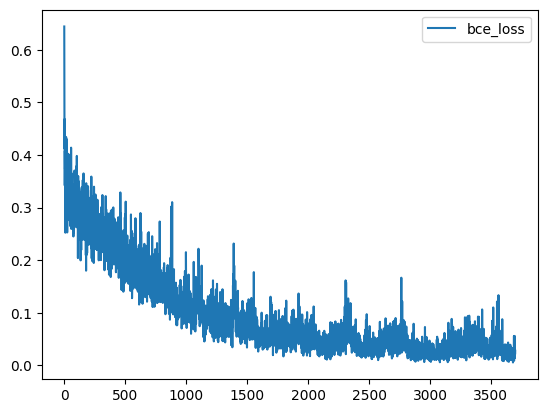

In [23]:
## train 
hidden_dim = 64
code_dim = 64
n_clusters = 2

epochs = 100
batch_size = 256
device = 'cuda:0'

set_random_seed(42)

# create dataset
train_dataset = TimeSeriesDataset(train_data.unsqueeze(1), train_labels) # channel last
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0, drop_last=True)

print("Testing dataloader")
for batch in train_dataloader:
    print(f"{batch[0].shape=}, {batch[1].shape=}")
    break
    
network = Network(input_dim=train_dataset[0][0].size(0), hidden_dim=hidden_dim, code_dim=code_dim, output_dim=n_clusters)
network = network.to(device)
# print(network)

optim = torch.optim.AdamW(network.parameters(), lr=0.003)

network.train()
pbar = tqdm(len(train_dataloader), position=0, leave=True)

loss_hist = defaultdict(list)
for epoch in range(epochs):
    
    epoch_loss = defaultdict(int)
    
    time_start = time.time()
    for i, batch in enumerate(train_dataloader):
        pbar.update(1)
        
        x, labels = batch[0].to(device), batch[1].to(device)
        
        loss_dict, probs = network(x, labels)
        
        loss = 0
        for k, v in loss_dict.items():
            loss += v
            epoch_loss[k] += v
            loss_hist[k].append(v.detach().item())
            
        epoch_loss['total_loss'] += loss
        string = ", ".join([f"{k}:{v/(i+1):.6f}" for k, v in epoch_loss.items()])
        pbar.set_postfix_str(string)

        optim.zero_grad()

        loss.backward()
        optim.step()
 
    print(f"{epoch=}, etc={time.time()-time_start:.3f}secs, {string}")
    # break

pbar.close()
print(f"Done!!!")

fig, axes = plt.subplots(len(loss_hist), 1)
i = 0
for k, v in loss_hist.items():
    axes.plot(v, label=k)
    axes.legend()
    i += 1


### Evaluation

inputs.shape=torch.Size([35, 1, 256]), class_prediction.shape=(35,)
input_signal.shape=(8759,), mapped_classes.shape=(8759,)


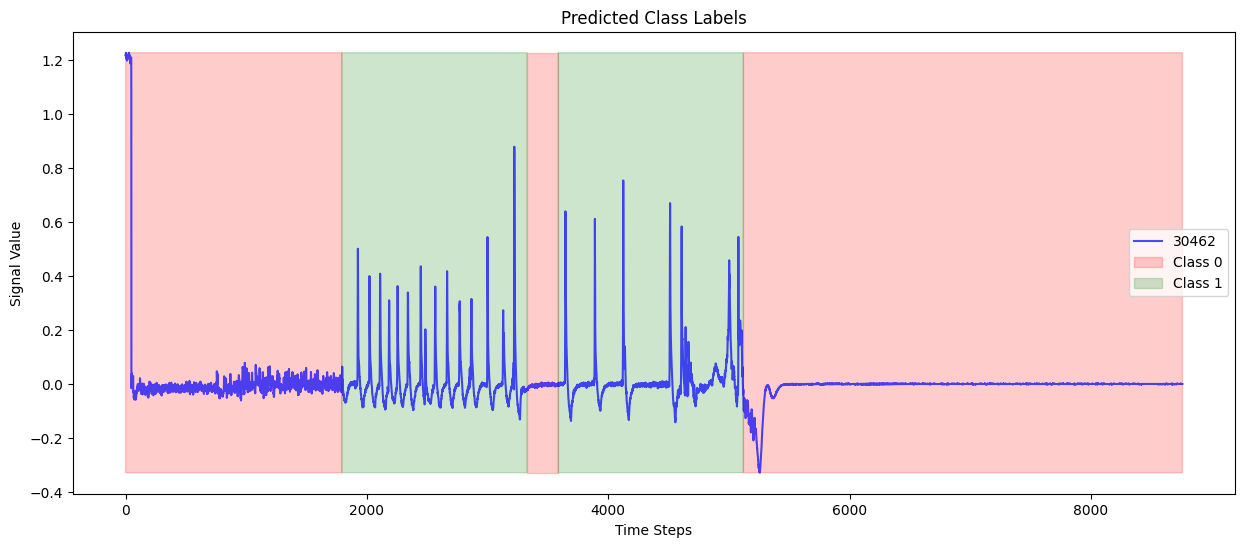

In [25]:
shot_id = '30462'
binary_th = 0.5
network.eval()
with torch.no_grad(): 
    # process all signal in segments
    dalpha_seg = segment_time_series(dalpha_values[shot_id], segment_length=context_length)
    
    inputs = torch.tensor(dalpha_seg).unsqueeze(1).to(device)
    inputs[inputs.isnan()] = 0

    probs = network(inputs)[1].cpu().numpy()
    class_prediction = np.argmax(probs>0.5, axis=-1)
    
    
print(f"{inputs.shape=}, {class_prediction.shape=}")

input_signal = dalpha_values[shot_id]

# mapped_classes = class_prediction.reshape(-1)[:len(input_signal)]
mapped_classes = np.repeat(class_prediction, context_length).reshape(-1)[:len(input_signal)]

print(f"{input_signal.shape=}, {mapped_classes.shape=}")
# Visualize dalpha
plt.figure(figsize=(15, 6))
plt.plot(input_signal, label=f"{shot_id}", color="blue", alpha=0.7)

colors = ['r', 'g', 'b', 'm']
# Overlay class labels as a heatmap
for i in range(n_clusters):
    plt.fill_between(
        range(len(input_signal)),
        input_signal.min(),
        input_signal.max(),
        where=(mapped_classes == i),
        color=colors[i],
        alpha=0.2,
        label=f"Class {i}",
    )

plt.title("Predicted Class Labels")
plt.xlabel("Time Steps")
plt.ylabel("Signal Value")
plt.legend()
plt.show()
